# Lap Efficiency Correlation Analysis

This notebook will compare multiple variables with lap efficiency to find possible covariates that will help us optimze for lap efficiency.

### Imports

In [68]:
from data_tools.collections.time_series import TimeSeries
from data_tools.query.influxdb_query import DBClient
from data_tools.collections.fsgp_2024_laps import FSGPDayLaps
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Open Meteo API
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry


FSGP_TRACK_LEN_M = 5_070

driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


### Getting Lap Efficiencies

We reuse functions previously made by [Jonah Lee](https://github.com/UBC-Solar/data_analysis/pull/2). Check his PR, linked on his name, for more information on the below functions, or refer to his original notebook [fsgp_2024_lap_efficiency.ipynb](./fsgp_2024_lap_efficiency.ipynb).


In [69]:
def calculate_lap_power(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    
    print(f"{start_time=}\n{end_time=}")
    
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage")
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")
    
    # Align x-axes
    raw_motor_current, motor_voltage, motor_current_dir = TimeSeries.align(raw_motor_current, motor_voltage, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1
    
    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

In [70]:
def calculate_lap_energy(start_time: datetime, end_time: datetime, client) -> TimeSeries:
    motor_power = calculate_lap_power(start_time, end_time, client)
    motor_energy = np.cumsum(motor_power) * motor_power.granularity
    motor_energy.units = "J"
    motor_energy.meta["field"] = "Motor Energy (regen adjusted)"
    return motor_energy

In [71]:
# Select which FSGP 2024 day to calculate lap efficiency for (1, 2 or 3)
laps1 = FSGPDayLaps(1)  # Corresponds to July 16th
laps3 = FSGPDayLaps(3)  # Corresponds to July 18th
day_1_idx = range(laps1.get_lap_count())
day_3_idx = range(laps3.get_lap_count())  # We are missing data after this point!
num_laps = len(day_1_idx) + len(day_3_idx)

lap_energies = []
lap_drivers = []
lap_speeds = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        
        lap_energies.append(calculate_lap_energy(lap_start, lap_end, data_client))
        lap_drivers.append(day_laps.get_lap_driver(lap_num))
        lap_speeds.append(day_laps.get_lap_mph(lap_num))

lap_energies = np.array([arr[-1] for arr in lap_energies])
lap_drivers = np.array(lap_drivers)
lap_speeds = np.array(lap_speeds)

start_time=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 40, 21, tzinfo=datetime.timezone.utc)
start_time=date

## Lap Efficiency and Average Speed (mph)

Below are plots of `lap efficiency` and `average speed` in miles per hour

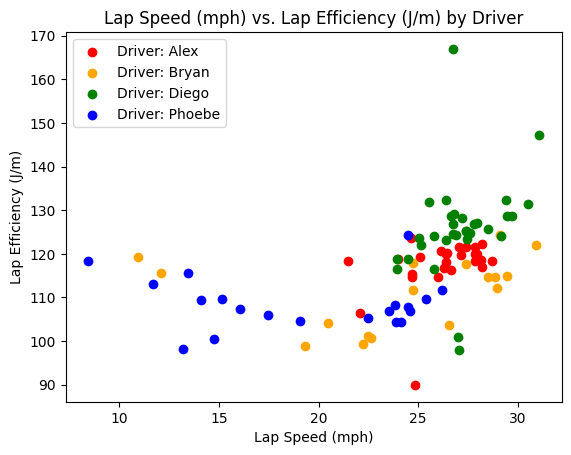

In [72]:
# Also from Jonah 
lap_efficiencies = lap_energies / FSGP_TRACK_LEN_M

for driver, colour in driver_colours.items():
    plt.scatter(lap_speeds[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Speed (mph) vs. Lap Efficiency (J/m) by Driver")
plt.show()

A quadratic relationship can be seen between `lap efficiency` and `average speed`, let's trying fitting a function to the data

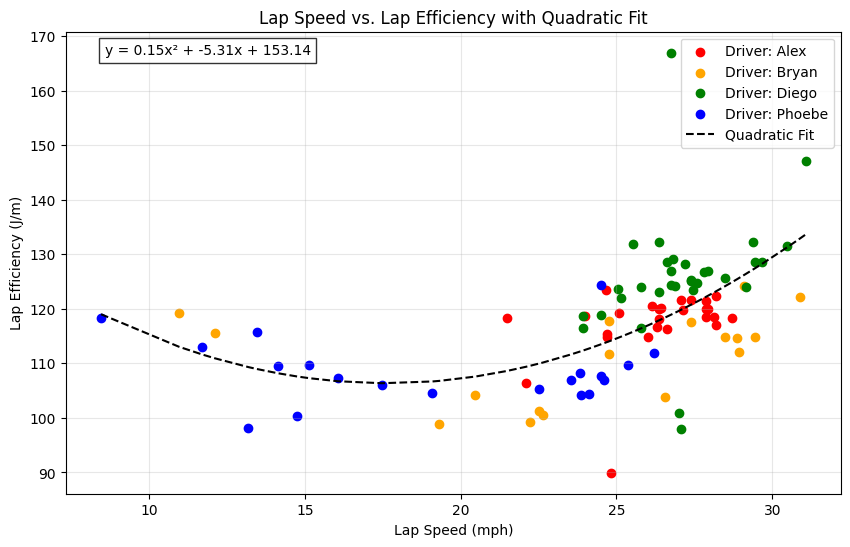

In [73]:
# Combine all data for the overall fit
all_speeds = np.array(lap_speeds)
all_efficiencies = np.array(lap_efficiencies)

# Sort data for plotting the fit line
sort_idx = np.argsort(all_speeds)
speeds_sorted = all_speeds[sort_idx]

# Define quadratic function for fitting
def quad_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the quadratic function
popt, _ = curve_fit(quad_func, all_speeds, all_efficiencies)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot individual driver points
for driver, colour in driver_colours.items():
    mask = lap_drivers == driver
    plt.scatter(lap_speeds[mask], lap_efficiencies[mask],
                c=colour, label=f"Driver: {driver}")

# Plot the fitted curve
fit_y = quad_func(speeds_sorted, *popt)
plt.plot(speeds_sorted, fit_y, 'k--', label='Quadratic Fit')

# Add labels and title
plt.xlabel("Lap Speed (mph)")
plt.ylabel("Lap Efficiency (J/m)")
plt.title("Lap Speed vs. Lap Efficiency with Quadratic Fit")
plt.legend()

# Add the equation to the plot
equation = f'y = {popt[0]:.2f}x² + {popt[1]:.2f}x + {popt[2]:.2f}'
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.show()

## Lap Efficiency and Average Battery Temp (C°)

Below are plots of `lap efficiency` and `average battery temp` in degrees celcius

In [74]:
lap_times = []
for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1

        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        lap_times.append((lap_start, lap_end))

In [75]:
battery_temps = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        battery_temp = data_client.query_time_series(lap_start, lap_end, "AverageTemp")    
        battery_temps.append(battery_temp.mean())

battery_temps = np.array(battery_temps)

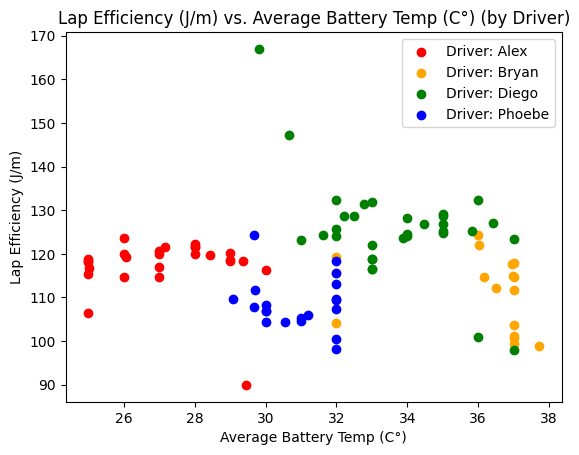

In [76]:
for driver, colour in driver_colours.items():
    plt.scatter(battery_temps[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}")
plt.xlabel("Average Battery Temp (C°)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Average Battery Temp (C°) (by Driver)")
plt.show()

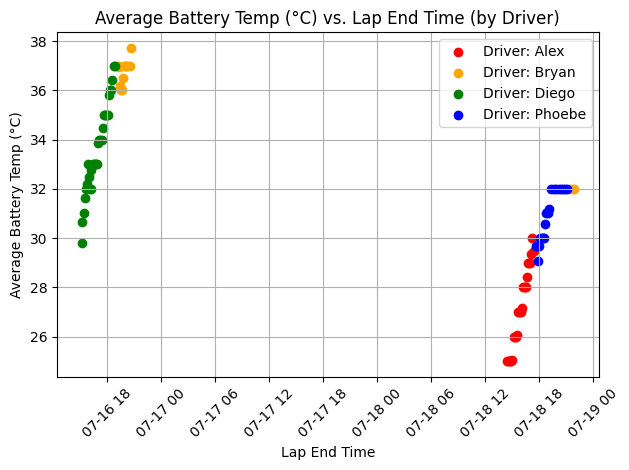

In [77]:
# Extract lap end times
lap_end_times = [lap_end for lap_start, lap_end in lap_times]

# Plot lap end times against average battery temperature
for driver, colour in driver_colours.items():
    plt.scatter(
        [lap_end_times[i] for i in range(len(lap_end_times)) if lap_drivers[i] == driver],
        [battery_temps[i] for i in range(len(battery_temps)) if lap_drivers[i] == driver],
        c=colour,
        label=f"Driver: {driver}"
    )

plt.xlabel("Lap End Time")
plt.ylabel("Average Battery Temp (°C)")
plt.legend()
plt.title("Average Battery Temp (°C) vs. Lap End Time (by Driver)")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Lap Efficiency and Average Wind Speed (m/s)

Below are plots of `lap efficiency` and `average wind speed` in m/s 

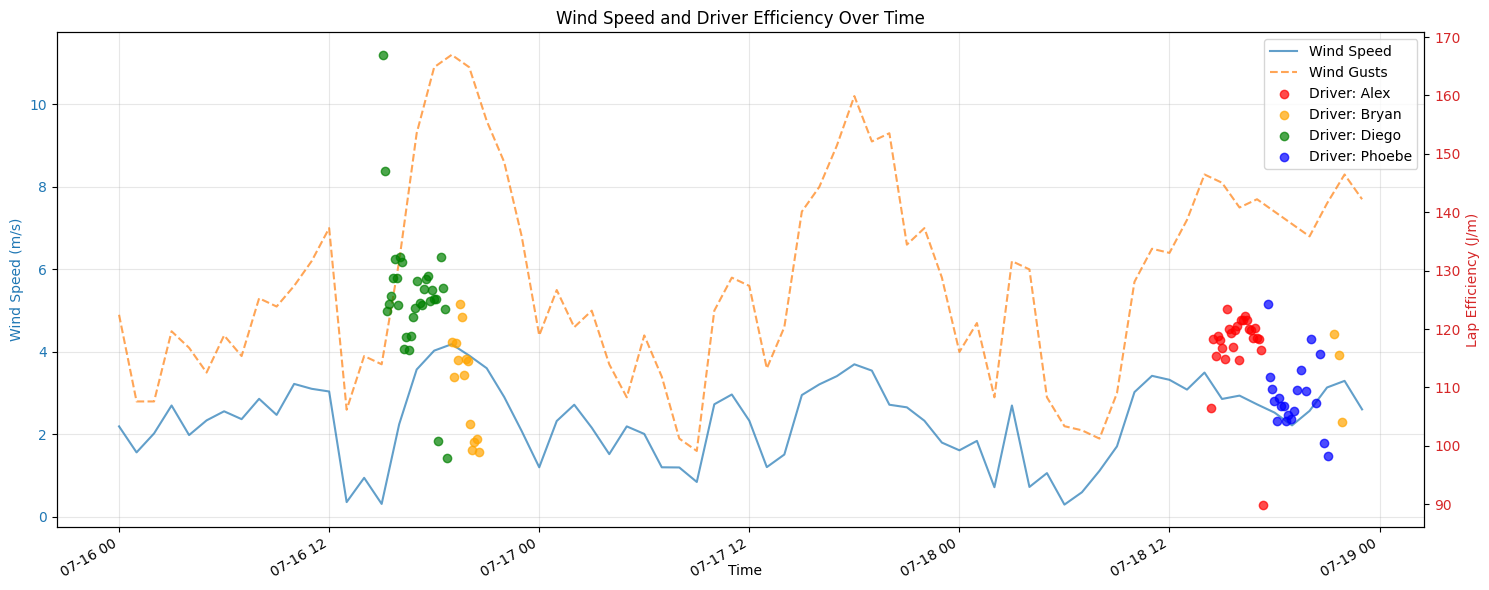

In [78]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def fetch_wind_data(latitude, longitude, start_date, end_date):
    """
    Fetch hourly wind speed data from Open-Meteo API
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["wind_speed_10m", "wind_gusts_10m"],
        "wind_speed_unit": "ms"  # Using m/s for scientific analysis
    }
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    
    # Process hourly data
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
            end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
            freq = pd.Timedelta(seconds = hourly.Interval()),
            inclusive = "left"
        ),
        "wind_speed": hourly.Variables(0).ValuesAsNumpy(),
        "wind_gusts": hourly.Variables(1).ValuesAsNumpy(),
    }
    
    return pd.DataFrame(data = hourly_data)

def plot_wind_analysis(df, lap_efficiencies, lap_times, lap_drivers):
    """
    Create a combined plot of wind data and driver efficiencies with two y-axes.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot wind data on primary y-axis (left)
    ax1.plot(df['date'], df['wind_speed'], label='Wind Speed', color='tab:blue', alpha=0.7)
    ax1.plot(df['date'], df['wind_gusts'], label='Wind Gusts', color='tab:orange', linestyle='--', alpha=0.7)
    ax1.set_ylabel('Wind Speed (m/s)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    # Set up secondary y-axis for lap efficiencies (right)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Lap Efficiency (J/m)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Calculate lap midpoints for plotting
    lap_midpoints = [lap_start + (lap_end - lap_start) / 2 for lap_start, lap_end in lap_times]

    # Plot each driver's efficiencies on secondary y-axis
    for driver, color in driver_colours.items():
        mask = np.array(lap_drivers) == driver
        if np.any(mask):
            ax2.scatter(
                [lap_midpoints[i] for i in range(len(lap_midpoints)) if mask[i]],
                [lap_efficiencies[i] for i in range(len(lap_efficiencies)) if mask[i]],
                color=color,
                label=f"Driver: {driver}",
                alpha=0.7
            )
    
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Format x-axis to show dates nicely
    fig.text(0.5, 0.04, 'Time', ha='center', va='center')
    plt.title('Wind Speed and Driver Efficiency Over Time')
    plt.xlabel('Time')
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()


# lat lon for center of track
latitude = 37.00272354871939
longitude = -86.36671627935802
start_date = "2024-07-16"  # FSGP Day 1
end_date = "2024-07-18"    # FSGP Day 3

df = fetch_wind_data(latitude, longitude, start_date, end_date)
plot_wind_analysis(df, lap_efficiencies, lap_times, lap_drivers)

## Lap Efficiency and Regen Energy

In [79]:
def get_regen_energy(motor_power: TimeSeries) -> TimeSeries:
    """
    Calculate the regen energy for a given motor power time series.
    """
    # Calculate the regen energy by integrating the regen power
    regen_power = motor_power[motor_power < 0]
    if len(regen_power) == 0: # no regen power
        return 0.0
    regen_energy = np.cumsum(regen_power) * regen_power.granularity
 
    return abs(regen_energy[-1])

In [80]:
regen_energy = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        motor_power = calculate_lap_power(lap_start, lap_end, data_client)
        regen_energy.append(get_regen_energy(motor_power))

regen_energy = np.array(regen_energy)

start_time=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
start_time=datetime.datetime(2024, 7, 16, 15, 33, 59, tzinfo=datetime.timezone.utc)
end_time=datetime.datetime(2024, 7, 16, 15, 40, 21, tzinfo=datetime.timezone.utc)
start_time=date

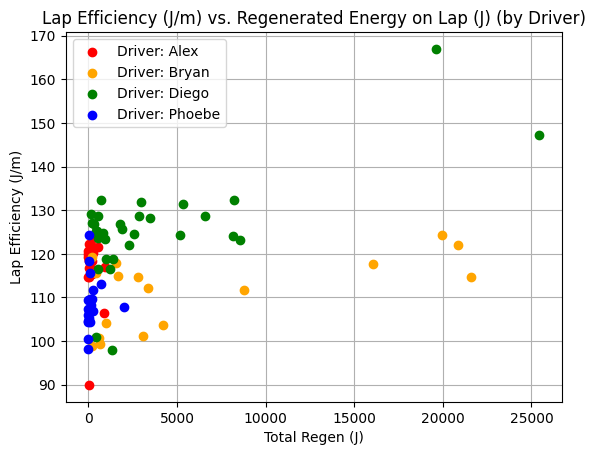

In [81]:
for driver, colour in driver_colours.items():
    plt.scatter(regen_energy[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Total Regen (J)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Regenerated Energy on Lap (J) (by Driver)")
plt.grid(zorder=1)  
plt.show()

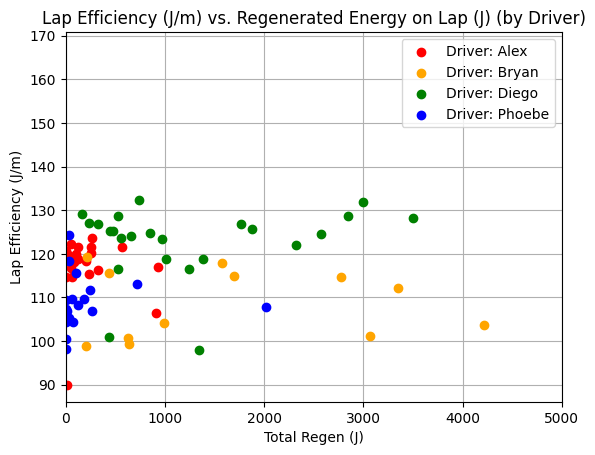

In [82]:
for driver, colour in driver_colours.items():
    plt.scatter(regen_energy[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Total Regen (J)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Regenerated Energy on Lap (J) (by Driver)")
plt.grid(zorder=1)  
plt.xlim(0, 5000)
plt.show()

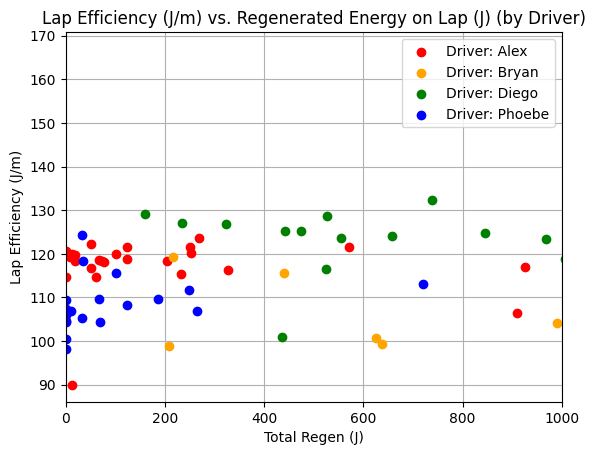

In [83]:
for driver, colour in driver_colours.items():
    plt.scatter(regen_energy[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Total Regen (J)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency (J/m) vs. Regenerated Energy on Lap (J) (by Driver)")
plt.grid(zorder=1)  
plt.xlim(0, 1000)
plt.show()

In [84]:
avg_pack_current = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        pack_currents = data_client.query_time_series(lap_start, lap_end, "PackCurrent")    
        avg_pack_current.append(pack_currents.mean())

avg_pack_current = np.array(avg_pack_current)

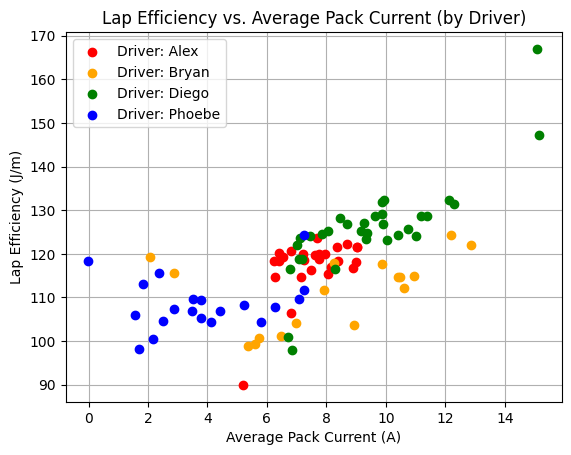

In [85]:
for driver, colour in driver_colours.items():
    plt.scatter(avg_pack_current[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Average Pack Current (A)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency vs. Average Pack Current (by Driver)")
plt.grid(zorder=1)  
plt.show()

In [86]:
avg_motor_current = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)

        raw_motor_current: TimeSeries = data_client.query_time_series(lap_start, lap_end, "BatteryCurrent")
        motor_current_dir: TimeSeries = data_client.query_time_series(lap_start, lap_end, "BatteryCurrentDirection")
            
        # Align x-axes
        raw_motor_current, motor_current_dir = TimeSeries.align(raw_motor_current, motor_current_dir)
        # Make direction -1 or 1 instead of 1 or 0
        motor_current_sign = motor_current_dir * -2 + 1

        # Account for regen direction
        motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
        avg_motor_current.append(motor_current.mean())

avg_motor_current = np.array(avg_motor_current)    

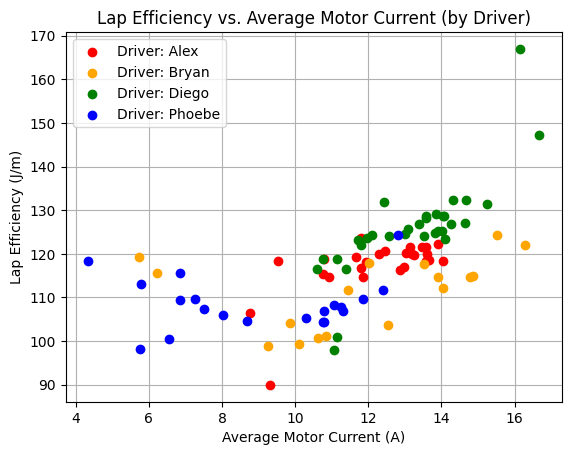

In [87]:
for driver, colour in driver_colours.items():
    plt.scatter(avg_motor_current[lap_drivers == driver],
                lap_efficiencies[lap_drivers == driver],
                c=colour,
                label=f"Driver: {driver}",
                zorder=2)
plt.xlabel("Average Motor Current (A)")
plt.ylabel("Lap Efficiency (J/m)")
plt.legend()
plt.title(f"Lap Efficiency vs. Average Motor Current (by Driver)")
plt.grid(zorder=1)  
plt.show()